### 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib
import matplotlib.pyplot as plt  # 파이플롯 사용
from IPython.display import set_matplotlib_formats
import seaborn as sns
sns.set_style('whitegrid')


set_matplotlib_formats('retina')  # 한글코드를 더 선명하게 해주는 조치, 레티나 설정
matplotlib.rc('font', family='AppleGothic') # 폰트 설정
matplotlib.rc('axes', unicode_minus=False) # 마이너스 폰트가 깨지는 경우가 있으므로 조치


# 데이터셋 가져오기
import requests
import wget

In [3]:
# data file url (실시간 데이터)
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

# 파일 다운
for url in urls:
    filename = wget.download(url)

In [13]:
# data
conf_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recv_df = pd.read_csv('time_series_covid19_recovered_global.csv')

### 날짜 데이터 처리하기

In [14]:
# 데이터에서 Date만 따로 추출
dates = conf_df.columns[4:]

In [15]:
conf_df_long = conf_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

deaths_df_long = deaths_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

recv_df_long = recv_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Recovered')

recv_df_long = recv_df_long[recv_df_long['Country/Region']!='Canada']

print(conf_df_long.shape)
print(deaths_df_long.shape)
print(recv_df_long.shape)

(35644, 6)
(35644, 6)
(33768, 6)


In [16]:
#merge
full_table = pd.merge(left=conf_df_long, right=deaths_df_long, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])
full_table = pd.merge(left=full_table, right=recv_df_long, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])

full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0.0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0.0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0.0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0.0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0.0


In [17]:
# Date를 판다스 datetime 데이터 타입으로 바꿔줍니다

full_table['Date'] = pd.to_datetime(full_table['Date'])

In [18]:
# 데이터셋 완료

full_table.shape

(35644, 8)

### 피쳐 선택하기

1. recovered에 많은 양의 null이 불규칙하게 포진 ...
2. Province/State 에도 많은 양의 null이 불규칙하게 포진 ...

-> 결국 두 피쳐 버리고 작업해 보기로 함

In [19]:
df = full_table.drop(['Province/State', 'Recovered'], axis= 1)

In [20]:
# Confirmed에 -1 이라고 엉뚱하게 입력된 값 바로잡기

df.loc[df['Confirmed'] == -1, 'Confirmed'] = 0

In [21]:
# 피쳐와 타겟 구분

X_df = df.iloc[:,:-1]
y_df = df.iloc[:,-1]

In [22]:
# 날짜 데이터를, 첫 발병일로부터 며칠이나 지났는지로 변환 (int 데이터 타입이 필요)

X_df['Date'] = pd.Series(X_df['Date'] - X_df.iloc[0, 3])
X_df['Date'] = X_df['Date'].dt.days


### 피쳐 엔지니어링

1. 원핫인코딩 : Country/Region 피쳐가 명목범주라서 원핫인코딩 할 수밖에 없음
2. 로그변환 : 데이터가 극단적으로 0쪽에 많이 쏠려있음

In [23]:
# X_df에 원핫인코딩한 것도 따로 마련

X_df_ohe = pd.get_dummies(X_df, columns=['Country/Region'])


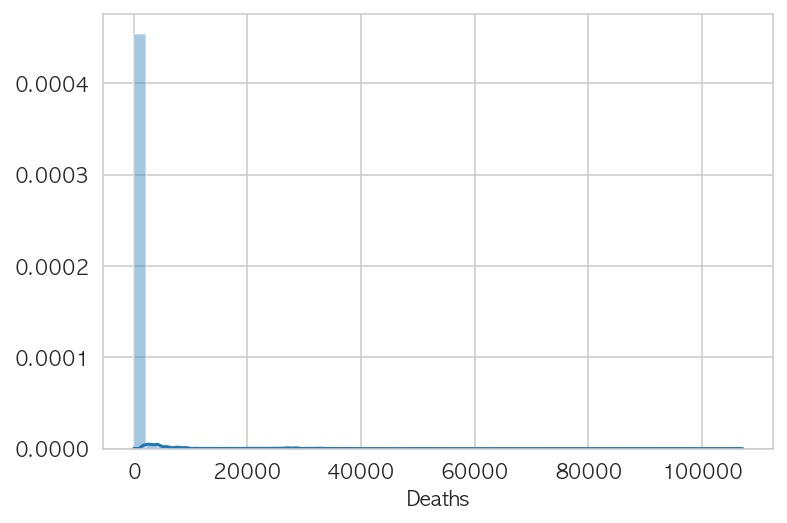

In [24]:
sns.distplot(y_df)

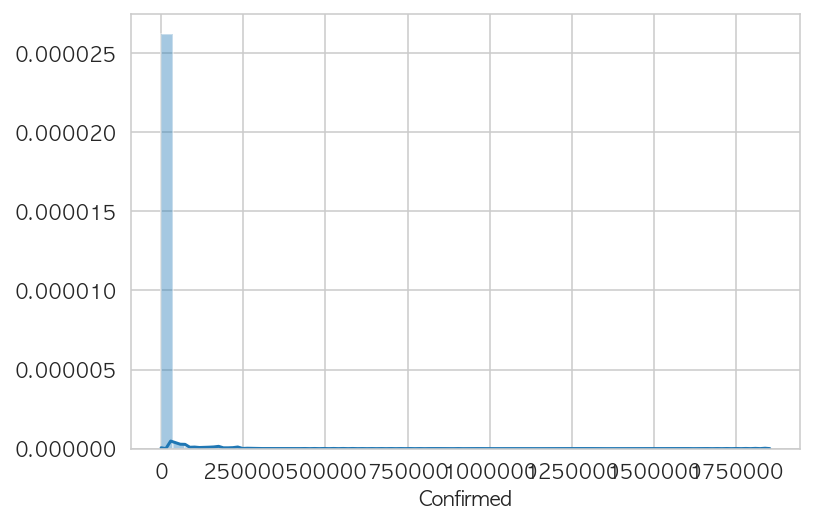

In [25]:
sns.distplot(X_df_ohe['Confirmed'])

In [26]:
# 로그변환 해야하는데 Log0이 계산되지 않으므로 0은 0.1로 살짝 바꿔줌


X_df_ohe.loc[X_df_ohe['Confirmed'] == 0, 'Confirmed'] = 0.1

y_df = pd.DataFrame(y_df)
y_df.loc[y_df['Deaths'] <= 0 , 'Deaths'] = 0.1
y_df = y_df['Deaths']

In [27]:
# 확진자 로그변환

X_df_ohe['Confirmed'] = np.log1p(X_df_ohe['Confirmed'])


### 데이터 스플릿

1. 케글에서 따로 test 데이터를 제공하지 않기 때문에, 사이킷런의 스플릿 api를 써서 자체적인 test 데이터셋 생성
2. random_state = 0

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df_ohe, y_df, test_size=0.2, random_state=0)


# 타겟은 일단 train 데이터만 로그변환 해줌 -> 나중에 최종적으로 pred와 y_test를 맞춰볼 때 pred를 재변환해서 비교하기
y_train = np.log1p(y_train)


In [32]:
# 알고리즘에서 원핫인코딩된 지역 이름 피쳐를 인식하지 못하므로 그냥 바꿔줌
X_df_ohe.columns = range(len(X_df_ohe.columns))
X_df_ohe.columns

RangeIndex(start=0, stop=192, step=1)

In [30]:
# 평가 함수 제작 (교재 참고)

from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

In [ ]:
# 회귀 알고리즘 적용
# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행 (회귀트리를 적용한 것)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)



# 위에서 제작한 평가함수 + 사용하고자 하는 회귀 알고리즘을 자동적으로 진행하는 함수
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))


def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)  # 
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred_exp)


# 4개의 회귀 알고리즘으로 스플릿 데이터에 대해 예측 및 평가 실행
for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test)

In [386]:
# 결과물

### RandomForestRegressor ###
RMSLE: 0.115, RMSE: 79.468, MAE: 8.553
### GradientBoostingRegressor ###
RMSLE: 0.331, RMSE: 878.894, MAE: 92.979
[15:20:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/taewoongkong/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


### XGBRegressor ###
RMSLE: 0.331, RMSE: 874.520, MAE: 90.971
### LGBMRegressor ###
RMSLE: 0.125, RMSE: 218.474, MAE: 24.668


## 결론 : Randomforest가 예측 맛집이었다